# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_Adam'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = ExponentialLR(optimizer, gamma=0.95)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.001

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100] :


1 Train: 100%|███████| 391/391 [00:19<00:00, 20.14it/s]

Train Loss: 1.7070 | Train Acc: 38.08%


Test  Loss: 1.4752 | Test Acc: 46.59%
updated best eval loss : 1.4752099302750599
--------------------------------------------------
[Epoch 2/100] :


2 Train: 100%|███████| 391/391 [00:29<00:00, 13.45it/s]


Train Loss: 1.2705 | Train Acc: 54.80%
Test  Loss: 1.2859 | Test Acc: 54.95%
updated best eval loss : 1.2858763344680206
--------------------------------------------------
[Epoch 3/100] :


3 Train: 100%|███████| 391/391 [00:30<00:00, 12.70it/s]


Train Loss: 1.0773 | Train Acc: 61.99%
Test  Loss: 1.0387 | Test Acc: 63.62%
updated best eval loss : 1.0387116957314406
--------------------------------------------------
[Epoch 4/100] :


4 Train: 100%|███████| 391/391 [00:31<00:00, 12.45it/s]


Train Loss: 0.9696 | Train Acc: 66.39%
Test  Loss: 1.2088 | Test Acc: 60.86%
--------------------------------------------------
[Epoch 5/100] :


5 Train: 100%|███████| 391/391 [00:30<00:00, 12.95it/s]


Train Loss: 0.8877 | Train Acc: 68.89%
Test  Loss: 1.0045 | Test Acc: 66.66%
updated best eval loss : 1.0045399137690096
--------------------------------------------------
[Epoch 6/100] :


6 Train: 100%|███████| 391/391 [00:29<00:00, 13.26it/s]


Train Loss: 0.8388 | Train Acc: 70.46%
Test  Loss: 1.5567 | Test Acc: 55.66%
--------------------------------------------------
[Epoch 7/100] :


7 Train: 100%|███████| 391/391 [00:28<00:00, 13.60it/s]


Train Loss: 0.7946 | Train Acc: 72.24%
Test  Loss: 0.7581 | Test Acc: 74.40%
updated best eval loss : 0.7581109683724898
--------------------------------------------------
[Epoch 8/100] :


8 Train: 100%|███████| 391/391 [00:29<00:00, 13.45it/s]


Train Loss: 0.7579 | Train Acc: 73.59%
Test  Loss: 1.1934 | Test Acc: 65.07%
--------------------------------------------------
[Epoch 9/100] :


9 Train: 100%|███████| 391/391 [00:32<00:00, 11.92it/s]


Train Loss: 0.7279 | Train Acc: 74.49%
Test  Loss: 0.7311 | Test Acc: 75.40%
updated best eval loss : 0.7311382516275479
--------------------------------------------------
[Epoch 10/100] :


10 Train: 100%|██████| 391/391 [00:35<00:00, 11.13it/s]


Train Loss: 0.7006 | Train Acc: 75.62%
Test  Loss: 0.7830 | Test Acc: 73.36%
--------------------------------------------------
[Epoch 11/100] :


11 Train: 100%|██████| 391/391 [00:47<00:00,  8.20it/s]


Train Loss: 0.6741 | Train Acc: 76.50%
Test  Loss: 0.6531 | Test Acc: 77.58%
updated best eval loss : 0.6531210458731349
--------------------------------------------------
[Epoch 12/100] :


12 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.6546 | Train Acc: 77.31%
Test  Loss: 0.7003 | Test Acc: 76.33%
--------------------------------------------------
[Epoch 13/100] :


13 Train: 100%|██████| 391/391 [00:35<00:00, 10.94it/s]


Train Loss: 0.6358 | Train Acc: 77.89%
Test  Loss: 0.6799 | Test Acc: 77.30%
--------------------------------------------------
[Epoch 14/100] :


14 Train: 100%|██████| 391/391 [00:34<00:00, 11.42it/s]


Train Loss: 0.6148 | Train Acc: 78.70%
Test  Loss: 0.5888 | Test Acc: 80.20%
updated best eval loss : 0.5887619072123419
--------------------------------------------------
[Epoch 15/100] :


15 Train: 100%|██████| 391/391 [00:36<00:00, 10.64it/s]


Train Loss: 0.6030 | Train Acc: 79.04%
Test  Loss: 0.6134 | Test Acc: 80.02%
--------------------------------------------------
[Epoch 16/100] :


16 Train: 100%|██████| 391/391 [00:34<00:00, 11.40it/s]


Train Loss: 0.5899 | Train Acc: 79.52%
Test  Loss: 0.6693 | Test Acc: 77.96%
--------------------------------------------------
[Epoch 17/100] :


17 Train: 100%|██████| 391/391 [00:34<00:00, 11.35it/s]


Train Loss: 0.5741 | Train Acc: 79.92%
Test  Loss: 0.5659 | Test Acc: 80.84%
updated best eval loss : 0.565921508058717
--------------------------------------------------
[Epoch 18/100] :


18 Train: 100%|██████| 391/391 [00:33<00:00, 11.55it/s]


Train Loss: 0.5654 | Train Acc: 80.34%
Test  Loss: 0.7289 | Test Acc: 76.23%
--------------------------------------------------
[Epoch 19/100] :


19 Train: 100%|██████| 391/391 [00:34<00:00, 11.20it/s]


Train Loss: 0.5468 | Train Acc: 80.92%
Test  Loss: 0.7315 | Test Acc: 76.86%
--------------------------------------------------
[Epoch 20/100] :


20 Train: 100%|██████| 391/391 [00:33<00:00, 11.75it/s]


Train Loss: 0.5362 | Train Acc: 81.25%
Test  Loss: 0.5701 | Test Acc: 80.52%
--------------------------------------------------
[Epoch 21/100] :


21 Train: 100%|██████| 391/391 [00:35<00:00, 10.94it/s]


Train Loss: 0.5214 | Train Acc: 81.69%
Test  Loss: 0.4712 | Test Acc: 83.65%
updated best eval loss : 0.4711995856671394
--------------------------------------------------
[Epoch 22/100] :


22 Train: 100%|██████| 391/391 [00:35<00:00, 11.06it/s]


Train Loss: 0.5194 | Train Acc: 82.08%
Test  Loss: 0.5249 | Test Acc: 81.97%
--------------------------------------------------
[Epoch 23/100] :


23 Train: 100%|██████| 391/391 [00:45<00:00,  8.59it/s]


Train Loss: 0.5112 | Train Acc: 82.18%
Test  Loss: 0.6468 | Test Acc: 78.33%
--------------------------------------------------
[Epoch 24/100] :


24 Train: 100%|██████| 391/391 [00:47<00:00,  8.29it/s]


Train Loss: 0.4985 | Train Acc: 82.67%
Test  Loss: 0.5491 | Test Acc: 81.26%
--------------------------------------------------
[Epoch 25/100] :


25 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.4945 | Train Acc: 82.60%
Test  Loss: 0.6422 | Test Acc: 78.35%
--------------------------------------------------
[Epoch 26/100] :


26 Train: 100%|██████| 391/391 [00:51<00:00,  7.66it/s]


Train Loss: 0.4860 | Train Acc: 82.90%
Test  Loss: 0.5565 | Test Acc: 81.09%
--------------------------------------------------
[Epoch 27/100] :


27 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.4713 | Train Acc: 83.39%
Test  Loss: 0.5519 | Test Acc: 81.04%
--------------------------------------------------
[Epoch 28/100] :


28 Train: 100%|██████| 391/391 [00:47<00:00,  8.28it/s]


Train Loss: 0.4693 | Train Acc: 83.62%
Test  Loss: 0.6043 | Test Acc: 80.27%
--------------------------------------------------
[Epoch 29/100] :


29 Train: 100%|██████| 391/391 [00:50<00:00,  7.71it/s]


Train Loss: 0.4615 | Train Acc: 83.95%
Test  Loss: 0.4539 | Test Acc: 84.43%
updated best eval loss : 0.4539485464367685
--------------------------------------------------
[Epoch 30/100] :


30 Train: 100%|██████| 391/391 [00:46<00:00,  8.49it/s]


Train Loss: 0.4582 | Train Acc: 84.10%
Test  Loss: 0.5955 | Test Acc: 79.32%
--------------------------------------------------
[Epoch 31/100] :


31 Train: 100%|██████| 391/391 [00:49<00:00,  7.83it/s]


Train Loss: 0.4500 | Train Acc: 84.27%
Test  Loss: 0.4964 | Test Acc: 83.65%
--------------------------------------------------
[Epoch 32/100] :


32 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.4428 | Train Acc: 84.57%
Test  Loss: 0.4753 | Test Acc: 84.10%
--------------------------------------------------
[Epoch 33/100] :


33 Train: 100%|██████| 391/391 [00:49<00:00,  7.89it/s]


Train Loss: 0.4365 | Train Acc: 84.81%
Test  Loss: 0.4769 | Test Acc: 84.45%
--------------------------------------------------
[Epoch 34/100] :


34 Train: 100%|██████| 391/391 [00:48<00:00,  8.12it/s]


Train Loss: 0.4331 | Train Acc: 84.92%
Test  Loss: 0.4475 | Test Acc: 84.61%
updated best eval loss : 0.44752523227583
--------------------------------------------------
[Epoch 35/100] :


35 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.4329 | Train Acc: 84.85%
Test  Loss: 0.4481 | Test Acc: 84.84%
--------------------------------------------------
[Epoch 36/100] :


36 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.4201 | Train Acc: 85.20%
Test  Loss: 0.4620 | Test Acc: 84.11%
--------------------------------------------------
[Epoch 37/100] :


37 Train: 100%|██████| 391/391 [00:50<00:00,  7.74it/s]


Train Loss: 0.4102 | Train Acc: 85.64%
Test  Loss: 0.4992 | Test Acc: 83.25%
--------------------------------------------------
[Epoch 38/100] :


38 Train: 100%|██████| 391/391 [00:47<00:00,  8.20it/s]


Train Loss: 0.4148 | Train Acc: 85.48%
Test  Loss: 0.4545 | Test Acc: 84.55%
--------------------------------------------------
[Epoch 39/100] :


39 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.4071 | Train Acc: 85.67%
Test  Loss: 0.5273 | Test Acc: 82.97%
--------------------------------------------------
[Epoch 40/100] :


40 Train: 100%|██████| 391/391 [00:48<00:00,  8.00it/s]


Train Loss: 0.4002 | Train Acc: 86.01%
Test  Loss: 0.4687 | Test Acc: 83.92%
--------------------------------------------------
[Epoch 41/100] :


41 Train: 100%|██████| 391/391 [00:48<00:00,  8.14it/s]


Train Loss: 0.3984 | Train Acc: 86.03%
Test  Loss: 0.4101 | Test Acc: 86.06%
updated best eval loss : 0.4100604992878588
--------------------------------------------------
[Epoch 42/100] :


42 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.3913 | Train Acc: 86.42%
Test  Loss: 0.4374 | Test Acc: 84.58%
--------------------------------------------------
[Epoch 43/100] :


43 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.3936 | Train Acc: 86.23%
Test  Loss: 0.5037 | Test Acc: 83.58%
--------------------------------------------------
[Epoch 44/100] :


44 Train: 100%|██████| 391/391 [00:50<00:00,  7.74it/s]


Train Loss: 0.3875 | Train Acc: 86.49%
Test  Loss: 0.4844 | Test Acc: 84.12%
--------------------------------------------------
[Epoch 45/100] :


45 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.3837 | Train Acc: 86.55%
Test  Loss: 0.5187 | Test Acc: 82.92%
--------------------------------------------------
[Epoch 46/100] :


46 Train: 100%|██████| 391/391 [00:49<00:00,  7.84it/s]


Train Loss: 0.3858 | Train Acc: 86.40%
Test  Loss: 0.3966 | Test Acc: 86.44%
updated best eval loss : 0.3966356665839123
--------------------------------------------------
[Epoch 47/100] :


47 Train: 100%|██████| 391/391 [00:47<00:00,  8.28it/s]


Train Loss: 0.3790 | Train Acc: 86.69%
Test  Loss: 0.4373 | Test Acc: 85.71%
--------------------------------------------------
[Epoch 48/100] :


48 Train: 100%|██████| 391/391 [00:48<00:00,  8.02it/s]


Train Loss: 0.3688 | Train Acc: 86.93%
Test  Loss: 0.4504 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 49/100] :


49 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.3621 | Train Acc: 87.42%
Test  Loss: 0.4708 | Test Acc: 84.57%
--------------------------------------------------
[Epoch 50/100] :


50 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.3699 | Train Acc: 87.12%
Test  Loss: 0.4146 | Test Acc: 86.48%
--------------------------------------------------
[Epoch 51/100] :


51 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.3627 | Train Acc: 87.37%
Test  Loss: 0.4185 | Test Acc: 86.15%
--------------------------------------------------
[Epoch 52/100] :


52 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.3578 | Train Acc: 87.36%
Test  Loss: 0.4109 | Test Acc: 86.56%
--------------------------------------------------
[Epoch 53/100] :


53 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.3595 | Train Acc: 87.44%
Test  Loss: 0.4096 | Test Acc: 86.17%
--------------------------------------------------
[Epoch 54/100] :


54 Train: 100%|██████| 391/391 [00:45<00:00,  8.55it/s]


Train Loss: 0.3577 | Train Acc: 87.44%
Test  Loss: 0.4603 | Test Acc: 84.84%
--------------------------------------------------
[Epoch 55/100] :


55 Train: 100%|██████| 391/391 [00:50<00:00,  7.76it/s]


Train Loss: 0.3488 | Train Acc: 87.77%
Test  Loss: 0.4387 | Test Acc: 86.49%
--------------------------------------------------
[Epoch 56/100] :


56 Train: 100%|██████| 391/391 [00:47<00:00,  8.29it/s]


Train Loss: 0.3461 | Train Acc: 87.94%
Test  Loss: 0.5186 | Test Acc: 83.61%
--------------------------------------------------
[Epoch 57/100] :


57 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.3418 | Train Acc: 88.00%
Test  Loss: 0.4229 | Test Acc: 85.64%
--------------------------------------------------
[Epoch 58/100] :


58 Train: 100%|██████| 391/391 [00:48<00:00,  8.12it/s]


Train Loss: 0.3363 | Train Acc: 88.21%
Test  Loss: 0.4532 | Test Acc: 85.31%
--------------------------------------------------
[Epoch 59/100] :


59 Train: 100%|██████| 391/391 [00:49<00:00,  7.85it/s]


Train Loss: 0.3442 | Train Acc: 87.99%
Test  Loss: 0.4392 | Test Acc: 85.63%
--------------------------------------------------
[Epoch 60/100] :


60 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.3387 | Train Acc: 87.98%
Test  Loss: 0.3798 | Test Acc: 87.38%
updated best eval loss : 0.37981401515912405
--------------------------------------------------
[Epoch 61/100] :


61 Train: 100%|██████| 391/391 [00:49<00:00,  7.84it/s]


Train Loss: 0.3355 | Train Acc: 88.14%
Test  Loss: 0.4553 | Test Acc: 85.57%
--------------------------------------------------
[Epoch 62/100] :


62 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.3280 | Train Acc: 88.36%
Test  Loss: 0.4115 | Test Acc: 86.40%
--------------------------------------------------
[Epoch 63/100] :


63 Train: 100%|██████| 391/391 [00:50<00:00,  7.82it/s]


Train Loss: 0.3302 | Train Acc: 88.44%
Test  Loss: 0.4195 | Test Acc: 86.35%
--------------------------------------------------
[Epoch 64/100] :


64 Train: 100%|██████| 391/391 [00:47<00:00,  8.25it/s]


Train Loss: 0.3311 | Train Acc: 88.29%
Test  Loss: 0.4451 | Test Acc: 86.32%
--------------------------------------------------
[Epoch 65/100] :


65 Train: 100%|██████| 391/391 [00:49<00:00,  7.86it/s]


Train Loss: 0.3217 | Train Acc: 88.84%
Test  Loss: 0.4189 | Test Acc: 86.45%
--------------------------------------------------
[Epoch 66/100] :


66 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.3252 | Train Acc: 88.65%
Test  Loss: 0.4185 | Test Acc: 86.55%
--------------------------------------------------
[Epoch 67/100] :


67 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.3170 | Train Acc: 88.88%
Test  Loss: 0.4318 | Test Acc: 86.54%
--------------------------------------------------
[Epoch 68/100] :


68 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.3197 | Train Acc: 88.86%
Test  Loss: 0.4221 | Test Acc: 86.99%
--------------------------------------------------
[Epoch 69/100] :


69 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3143 | Train Acc: 88.90%
Test  Loss: 0.4149 | Test Acc: 86.89%
--------------------------------------------------
[Epoch 70/100] :


70 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.3092 | Train Acc: 89.17%
Test  Loss: 0.4029 | Test Acc: 87.16%
--------------------------------------------------
[Epoch 71/100] :


71 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.3059 | Train Acc: 89.33%
Test  Loss: 0.3992 | Test Acc: 87.53%
--------------------------------------------------
[Epoch 72/100] :


72 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.3120 | Train Acc: 88.96%
Test  Loss: 0.3563 | Test Acc: 88.26%
updated best eval loss : 0.3562913476666318
--------------------------------------------------
[Epoch 73/100] :


73 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.3083 | Train Acc: 89.36%
Test  Loss: 0.3862 | Test Acc: 87.22%
--------------------------------------------------
[Epoch 74/100] :


74 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.3000 | Train Acc: 89.38%
Test  Loss: 0.3690 | Test Acc: 88.60%
--------------------------------------------------
[Epoch 75/100] :


75 Train: 100%|██████| 391/391 [00:46<00:00,  8.32it/s]


Train Loss: 0.3026 | Train Acc: 89.25%
Test  Loss: 0.4870 | Test Acc: 85.01%
--------------------------------------------------
[Epoch 76/100] :


76 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.2987 | Train Acc: 89.54%
Test  Loss: 0.4554 | Test Acc: 85.35%
--------------------------------------------------
[Epoch 77/100] :


77 Train: 100%|██████| 391/391 [00:47<00:00,  8.31it/s]


Train Loss: 0.2951 | Train Acc: 89.57%
Test  Loss: 0.3836 | Test Acc: 87.53%
--------------------------------------------------
[Epoch 78/100] :


78 Train: 100%|██████| 391/391 [00:49<00:00,  7.85it/s]


Train Loss: 0.3046 | Train Acc: 89.41%
Test  Loss: 0.3743 | Test Acc: 87.98%
--------------------------------------------------
[Epoch 79/100] :


79 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.2963 | Train Acc: 89.54%
Test  Loss: 0.3992 | Test Acc: 87.42%
--------------------------------------------------
[Epoch 80/100] :


80 Train: 100%|██████| 391/391 [00:48<00:00,  8.14it/s]


Train Loss: 0.2963 | Train Acc: 89.57%
Test  Loss: 0.4670 | Test Acc: 85.53%
--------------------------------------------------
[Epoch 81/100] :


81 Train: 100%|██████| 391/391 [00:49<00:00,  7.82it/s]


Train Loss: 0.2954 | Train Acc: 89.56%
Test  Loss: 0.4347 | Test Acc: 86.78%
--------------------------------------------------
[Epoch 82/100] :


82 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.2913 | Train Acc: 89.70%
Test  Loss: 0.4219 | Test Acc: 86.59%
--------------------------------------------------
[Epoch 83/100] :


83 Train: 100%|██████| 391/391 [00:49<00:00,  7.82it/s]


Train Loss: 0.2893 | Train Acc: 89.92%
Test  Loss: 0.4249 | Test Acc: 86.92%
--------------------------------------------------
[Epoch 84/100] :


84 Train: 100%|██████| 391/391 [00:46<00:00,  8.42it/s]


Train Loss: 0.2839 | Train Acc: 89.98%
Test  Loss: 0.3786 | Test Acc: 87.70%
--------------------------------------------------
[Epoch 85/100] :


85 Train: 100%|██████| 391/391 [00:48<00:00,  8.12it/s]


Train Loss: 0.2902 | Train Acc: 89.84%
Test  Loss: 0.3838 | Test Acc: 88.16%
--------------------------------------------------
[Epoch 86/100] :


86 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.2888 | Train Acc: 89.93%
Test  Loss: 0.3931 | Test Acc: 87.04%
--------------------------------------------------
[Epoch 87/100] :


87 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.2798 | Train Acc: 90.19%
Test  Loss: 0.4590 | Test Acc: 85.91%
--------------------------------------------------
[Epoch 88/100] :


88 Train: 100%|██████| 391/391 [00:48<00:00,  8.07it/s]


Train Loss: 0.2860 | Train Acc: 90.05%
Test  Loss: 0.3645 | Test Acc: 88.09%
--------------------------------------------------
[Epoch 89/100] :


89 Train: 100%|██████| 391/391 [00:48<00:00,  8.13it/s]


Train Loss: 0.2845 | Train Acc: 89.94%
Test  Loss: 0.5930 | Test Acc: 82.82%
--------------------------------------------------
[Epoch 90/100] :


90 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.2807 | Train Acc: 90.19%
Test  Loss: 0.4136 | Test Acc: 86.70%
--------------------------------------------------
[Epoch 91/100] :


91 Train: 100%|██████| 391/391 [00:46<00:00,  8.43it/s]


Train Loss: 0.2806 | Train Acc: 90.12%
Test  Loss: 0.4084 | Test Acc: 87.25%
--------------------------------------------------
[Epoch 92/100] :


92 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.2799 | Train Acc: 90.13%
Test  Loss: 0.4062 | Test Acc: 86.88%
--------------------------------------------------
[Epoch 93/100] :


93 Train: 100%|██████| 391/391 [00:50<00:00,  7.69it/s]


Train Loss: 0.2742 | Train Acc: 90.49%
Test  Loss: 0.4144 | Test Acc: 87.06%
--------------------------------------------------
[Epoch 94/100] :


94 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.2743 | Train Acc: 90.30%
Test  Loss: 0.4017 | Test Acc: 87.42%
--------------------------------------------------
[Epoch 95/100] :


95 Train: 100%|██████| 391/391 [00:49<00:00,  7.82it/s]


Train Loss: 0.2734 | Train Acc: 90.36%
Test  Loss: 0.4199 | Test Acc: 87.09%
--------------------------------------------------
[Epoch 96/100] :


96 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.2700 | Train Acc: 90.70%
Test  Loss: 0.4047 | Test Acc: 87.37%
--------------------------------------------------
[Epoch 97/100] :


97 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.2683 | Train Acc: 90.53%
Test  Loss: 0.4305 | Test Acc: 86.58%
--------------------------------------------------
[Epoch 98/100] :


98 Train: 100%|██████| 391/391 [00:49<00:00,  7.84it/s]


Train Loss: 0.2691 | Train Acc: 90.59%
Test  Loss: 0.4031 | Test Acc: 87.17%
--------------------------------------------------
[Epoch 99/100] :


99 Train: 100%|██████| 391/391 [00:39<00:00, 10.01it/s]


Train Loss: 0.2674 | Train Acc: 90.59%
Test  Loss: 0.3804 | Test Acc: 88.19%
--------------------------------------------------
[Epoch 100/100] :


100 Train: 100%|█████| 391/391 [00:39<00:00,  9.97it/s]


Train Loss: 0.2674 | Train Acc: 90.68%
Test  Loss: 0.3928 | Test Acc: 88.20%
--------------------------------------------------


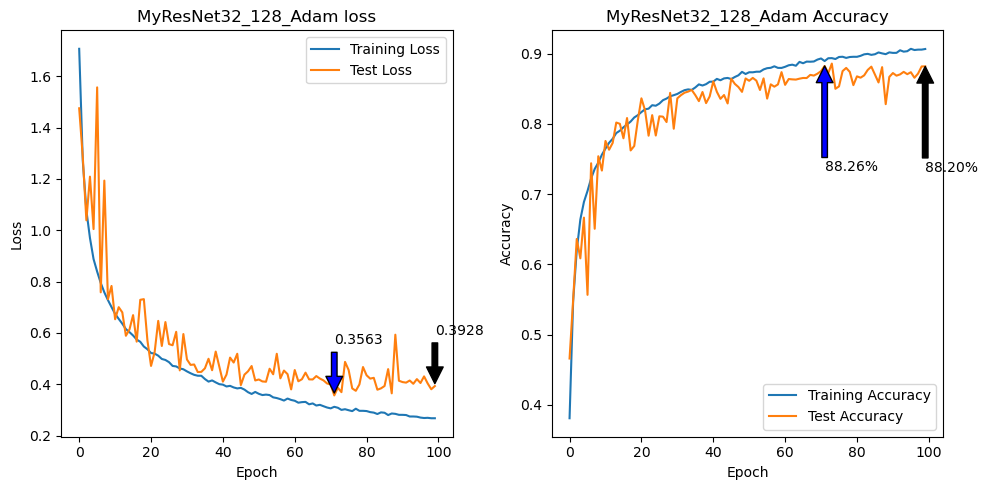

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=1.7070, train_acc=0.3808, test_loss=1.4752, test_acc=0.4659, lr=0.0010
2 epoch: train_loss=1.2705, train_acc=0.5480, test_loss=1.2859, test_acc=0.5495, lr=0.0010
3 epoch: train_loss=1.0773, train_acc=0.6199, test_loss=1.0387, test_acc=0.6362, lr=0.0010
4 epoch: train_loss=0.9696, train_acc=0.6639, test_loss=1.2088, test_acc=0.6086, lr=0.0010
5 epoch: train_loss=0.8877, train_acc=0.6889, test_loss=1.0045, test_acc=0.6666, lr=0.0010
6 epoch: train_loss=0.8388, train_acc=0.7046, test_loss=1.5567, test_acc=0.5566, lr=0.0010
7 epoch: train_loss=0.7946, train_acc=0.7224, test_loss=0.7581, test_acc=0.7440, lr=0.0010
8 epoch: train_loss=0.7579, train_acc=0.7359, test_loss=1.1934, test_acc=0.6507, lr=0.0010
9 epoch: train_loss=0.7279, train_acc=0.7449, test_loss=0.7311, test_acc=0.7540, lr=0.0010
10 epoch: train_loss=0.7006, train_acc=0.7562, test_loss=0.7830, test_acc=0.7336, lr=0.0010
11 epoch: train_loss=0.6741, train_acc=0.7650, test_loss=0.6531, test_acc=0.7758, lr=0.00